# Реализация архитектуры Compositional Pattern Producing Networks для генерации абстрактных картин

## Импорт необходимых библиотек
* torch - PyTorch - предоставляет функции работы с НС
* NumPy - для работы с матрицами
* MatPlotLib - вывод изображения 

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os, copy

### Переопределяем функцию случайного нормального распределения

In [62]:
def init_normal(m):
    if type(m) == nn.Linear:        
        nn.init.normal_(m.weight)

Функция init.normal_(Tensor tensor) заполняет входящий тензор значениями нормального распределения N(mean, std2),
где mean - среднее значение;
std2 - стандартное отклонение распределения


### Описываем класс и структуру нейросети
На вход конструктора подаётся функция активации (по умолчанию это гиперболический тангенс), количество нейронов и кол-во скрытых слоёв.

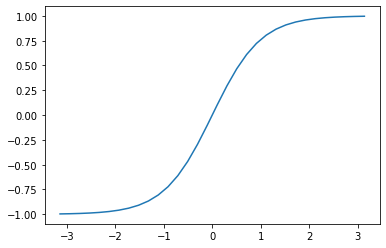

In [63]:
x = np.linspace(-np.pi, np.pi, 32)
f = np.tanh(x)
plt.plot(x,f);
# Гиперболический тангенс имеет следующий вид:

In [64]:
class NN(nn.Module):

    def __init__(self, activation=nn.Tanh, num_neurons=16, num_layers=4):
        super(NN, self).__init__()
        layers = [nn.Linear(2, num_neurons, bias=True), activation()]
        
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons, bias=False), activation()]
            
        layers += [nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Структура нейронной сети будет иметь следующий вид:
    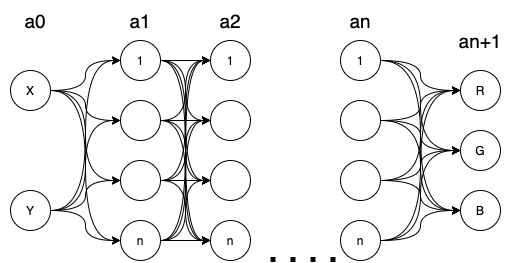
    
    num_layers - количество скрытых слоёв (от а1 до аn)
    num_neurons - количество нейронов на скрытых слоях (от 1 до n)

In [ ]:
layers = [nn.Linear(2, 16, bias=True), nn.Tanh]
for i in range(len(layers)):
    print(layers[i])
    
nn.Linear(2, 16, bias=True)

### Основная функция генерации изображения
На вход подаётся размеры по Х и У, флаг сохранения картинки и параметры (для конструктора НС)
Выходное значение функции будет трёхмерная матрица значений цвета для каждого пикселя (**colors**)

In [65]:
def gen_new_image(size_x, size_y, save=True, **params):
    net = NN(**params)
    net.apply(init_normal)
    colors = run_net(net, size_x, size_y)
    plot_colors(colors, size_x, size_y)
    if save is True:
        save_colors(colors)
    return net, colors

### Функция нормализации и заполнения матрицы цветов

In [94]:
def run_net(net, size_x=128, size_y=128):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 2))
    # Нормализуем матрицу цветов, ограничивая значение пикселей от -0.5 до 0.5
    for i in x:
        for j in y:
            colors[i][j] = np.array([float(i) / size_y - 0.5, float(j) / size_x - 0.5])
    img = net(torch.tensor(colors).type(torch.FloatTensor)).detach().numpy()
    return img.reshape(size_x, size_y, 3)

### ~~Визуалиционная магия~~ Вывод полученного изображения

In [67]:
def plot_colors(colors, size_x, size_y, fig_size=12):
    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(colors, interpolation='nearest', vmin=0, vmax=1)

In [68]:
def save_colors(colors):
    plt.imsave(str(np.random.randint(100000)) + ".png", colors)

In [69]:
def run_plot_save(net, size_x, size_y, fig_size=8):
    colors = run_net(net, size_x, size_y)
    plot_colors(colors, size_x, size_y, fig_size)
    save_colors(colors)

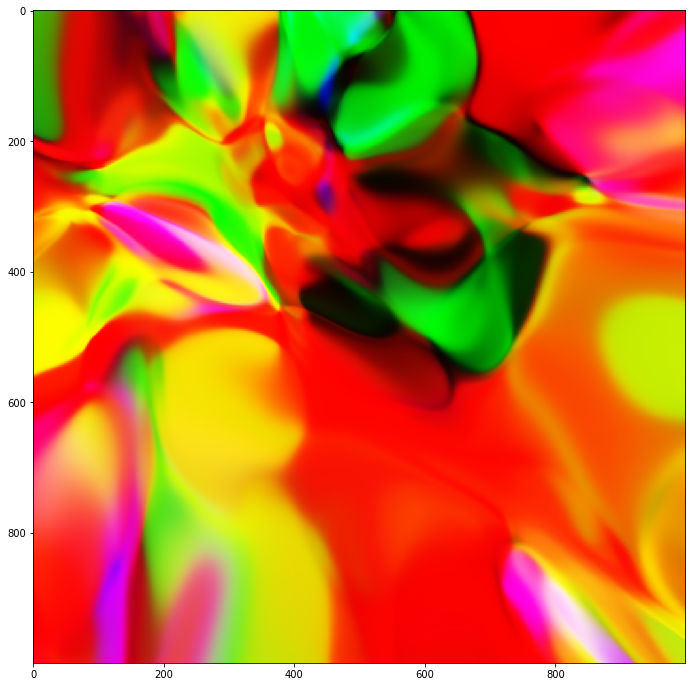

In [95]:
n,c = gen_new_image(1000, 1000, save=False, num_neurons=32, num_layers=6)

In [ ]:
run_plot_save(n, 1080, 720)

In [ ]:
n,c = gen_new_image(25, 25, save=False, num_neurons=24)

In [ ]:
for size in range(10, 500, 50):
    n,c = gen_new_image(size, size, save=False, num_layers=16)

In [ ]:
for i in range(1, 10, 2):
    print(f"{num_layers} layers")
    n,c = gen_new_image(128, 128, save=False, num_neurons=2**i)

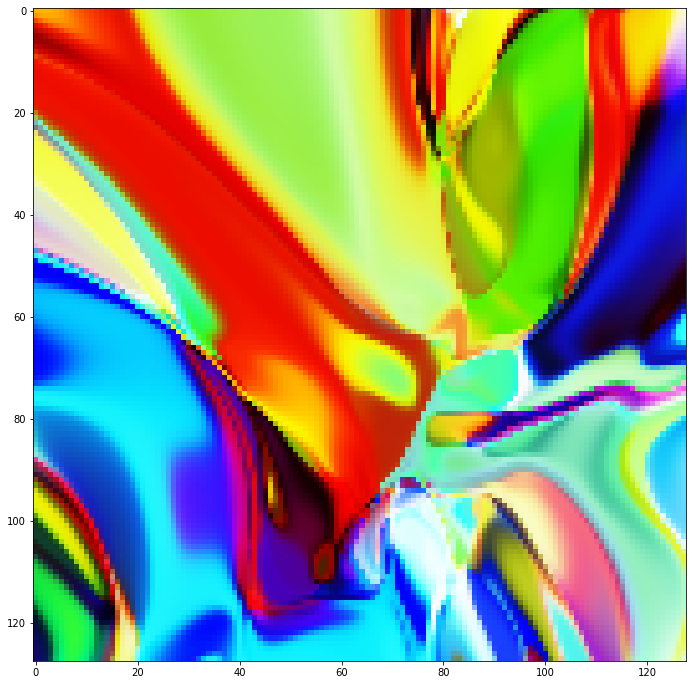

In [96]:
n,c = gen_new_image(128, 128, save=False, activation=nn.Tanh, num_neurons=16)

### Выводим случайные цитаты на сгенерированный арт

In [97]:
import random as rnd

pacan = [
    "Не проси у Бога денег\n - Злато счастья не дает...\n Не проси успеха в деле\n - есть талант –– успех придет.\n Попроси любви и веры,\n силы всех простить и жить,\n чтобы сердце не черствело...\n Попроси... себя простить.",
    "Просто потерпи,\nстанет легче к утру",
    "Забыв меня сегодня,\n не вспоминай меня завтра",
    "Порой бывает так тоскливо\nЧто даже чай не лезет в глотку\nА лезет в глотку только пиво\nКоторым запиваешь водку.",
    "У каждого человека бывает\n такой период в жизни,\n когда ему кажется,\n что он никому не нужен.",
    "Живи, братуха, и не думай, что кто-то\nпро тебя забыл.\n Друзья не забывают\nдруга, а кто забыл,\n тот не был им.",
    "Не важно, что важно\n важно кто важен"
]

In [104]:
def plot_colors(colors, size_x, size_y, fig_size=12):
    plt.figure(figsize=(fig_size, fig_size))
    plt.text(len(t)+size_x*0.3,size_y*0.5, t, 
             fontfamily='Times New Roman', va='center', ha='center',
             color='white', fontsize=42,
             fontweight=900, wrap=True)
    plt.imshow(colors, interpolation='nearest', vmin=0, vmax=1)

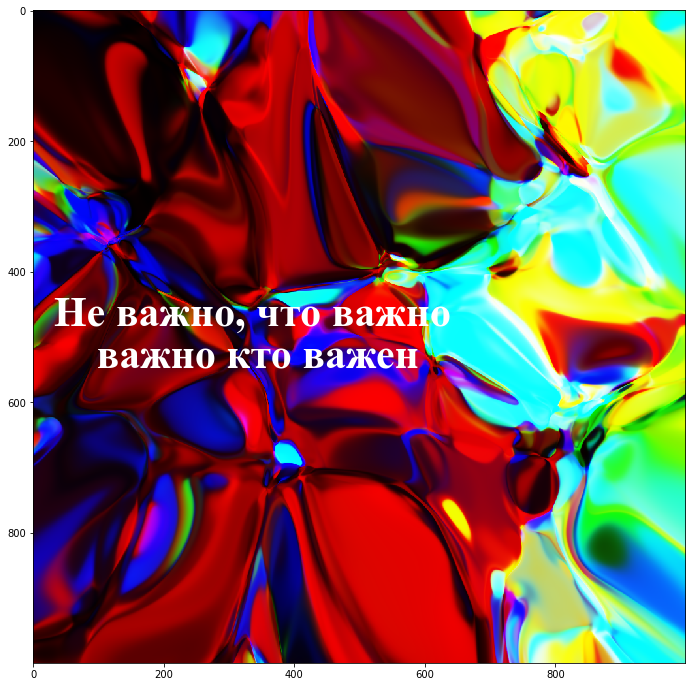

In [107]:
t = pacan[rnd.randint(0, len(pacan)-1)]
n,c = gen_new_image(1000, 1000, save=False, num_neurons=24)